# Exploring the EvalRS dataset

This notebook provides some basic EDA on the dataset of the [EvalRS](https://reclist.io/cikm2022-cup/) challenge.
Please refer to [our paper](https://arxiv.org/abs/2207.05772) for all the details.

With the goal of building a *all-around* recommender system, we likely want to understand how users, tracks and listening events are distributed, with a special case to *long tails* and rare (or new events). Yeah, you can thank us for the tip later.

Before we start, we need to check we are inside the right virtual environment

In [1]:
%%capture
# check we are using the right interpreter with the right RecList version
!which python
!pip install -r ../requirements.txt

In [2]:
import os
import sys
sys.path.insert(0, '../')

In [3]:
from evaluation.EvalRSRunner import ChallengeDataset

import gc
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("notebook")

Next, we have to download the dataset (~600MB) -- actually, you'll download it just the first time!

In [4]:
dataset = ChallengeDataset(force_download=False)

LFM dataset already downloaded. Skipping download.
Loading dataset.
Generating folds.
Generating dataset hashes.


And get a sample fold (see details on our Bootstrapping Cross-Validation evaluation strategy to know more about folds).

In [5]:
train, test = dataset.get_sample_train_test()
train.shape, test.shape

((6891962, 6), (29743, 2))

In [11]:
train.head()

,user_id,artist_id,album_id,track_id,timestamp,user_track_count
35,31435741,13,15,17,1381747153,23
111,31435741,21,31,53,1369855872,54
195,31435741,32,46,86,1369568484,84
198,31435741,44,65,127,1369058705,3
317,31435741,45,67,131,1368809563,119


In [13]:
train.head()

,user_id,artist_id,album_id,track_id,timestamp,user_track_count
35,31435741,13,15,17,1381747153,23
111,31435741,21,31,53,1369855872,54
195,31435741,32,46,86,1369568484,84
198,31435741,44,65,127,1369058705,3
317,31435741,45,67,131,1368809563,119


In [12]:
dataset.df_events

,user_id,artist_id,album_id,track_id,timestamp,user_track_count
1047889016,50967444,3059,114114,336613,1409538054,1
1047889017,50967444,3059,114114,336156,1409537916,1
1047889018,50967444,3059,114114,339139,1409537712,1
1047889019,50967444,3059,114114,338514,1409537546,1
1047889059,50967444,677,3035,674449,1409532988,1
...,...,...,...,...,...,...
323299984,384,7990,39548,177872,1388362330,2
323301513,384,289,8126,198978,1388361028,1
323301516,384,4166,184583,562698,1388360575,1
323302551,384,51469,132694,383962,1387472220,1


So. We have ~7M training listening records. Each tells us who (*user_id*) listened to what (*track_it*), when (*timestamp*), and how many times (*user_track_count*).

Let's now run some preprocessing to get started.

In [7]:
# convert the timestamp in a more convenient format
train["timestamp"] = pd.to_datetime(train["timestamp"], unit="s")

In [8]:
# add a column for Hour Of the Day
train["hod"] = train["timestamp"].dt.hour

We are ready to do some EDA.

## EDA on Tracks

Let's begin with a few statistics about tracks. We can inspect how many *unique* tracks are there! 

In [9]:
percentiles = np.arange(1, step=0.1)
gb_track = train.groupby("track_id")

**Q0: what's the Track distribution?**

In [10]:
track_records = gb_track.size()
track_records.describe(percentiles)

count    227612.000000
mean         30.322263
std          42.398014
min           7.000000
0%            7.000000
10%          10.000000
20%          12.000000
30%          13.000000
40%          15.000000
50%          17.000000
60%          21.000000
70%          27.000000
80%          36.000000
90%          59.000000
max        1591.000000
dtype: float64

There are ~230K distinct tracks. But wait. We know there is a `timestamp` feature, does that mean that a user can play the same track multiple times? Programmatically, we should check if the pair <`user`,`track`> does appear multiple times.

In [11]:
len(train.groupby(["user_id", "track_id"]).size()) == train.shape[0]

True

In [12]:
train.head()

,user_id,artist_id,album_id,track_id,timestamp,user_track_count,hod
2566,21072247,15,19,21,2013-07-23 11:50:22,3,11
2571,21072247,15,19,22,2013-07-21 22:23:39,5,22
2574,21072247,15,19,25,2013-07-23 11:41:47,3,11
2583,21072247,15,123,26,2012-10-28 10:15:18,9,10
2586,21072247,15,19,27,2013-07-23 11:30:11,3,11


The two sizes correspond: we can assume there are no <`user`,`track`> duplicates. Indeed, the `user_track_count` value lets us know the play count!

We also obtained a new information: `track_records` contains the number of distinct users that played a given track. Let's now observe the distribution graphically.

Text(0, 0.5, 'Track Count (log)')

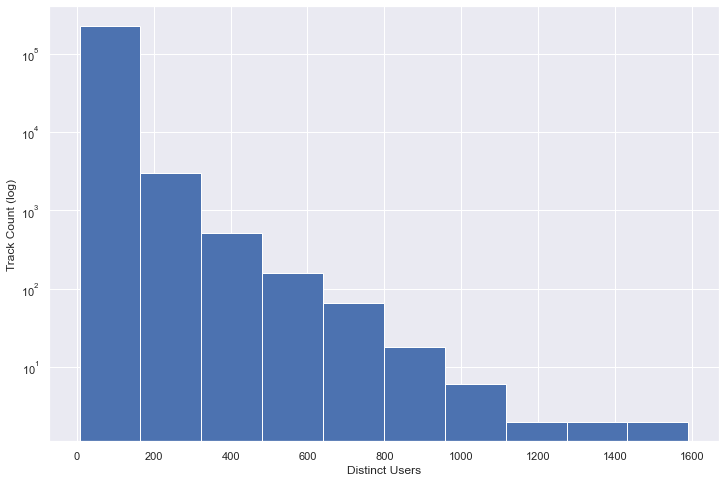

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(track_records)
ax.set_yscale("log")
ax.set_xlabel("Distinct Users")
ax.set_ylabel("Track Count (log)")

Let's look at the distribution in percentiles again. 

In [14]:
track_records.describe(percentiles)

count    227612.000000
mean         30.322263
std          42.398014
min           7.000000
0%            7.000000
10%          10.000000
20%          12.000000
30%          13.000000
40%          15.000000
50%          17.000000
60%          21.000000
70%          27.000000
80%          36.000000
90%          59.000000
max        1591.000000
dtype: float64

Tracks are listened by 30 distinct users on the average, and that 90% of them has less than 58 distinct users that played it. Further, there are some outliers: the maximum number of users is ~1600. Is this a very popular track or a dataset artifact? Let's find out.   

In [ ]:
K = 10
top_by_user = track_records.iloc[track_records.argsort().values[:-(K+1):-1]]
top_by_user.name = "distinct_user_count"

# Retrieve the task information from the `dataset` handler variable
dataset.df_tracks.loc[top_by_user.index].join(top_by_user)

Well, these song seem pretty popular, right? But something more came up... look at position **3** and **6**: there are two different versions of *Get Lucky*. Is this something you want your model to factor in at training time? 

**Q1: How many times does a user play the same song?**

We can use the handy `user_track_count` to measure how frequently users get engaged by songs (remember to take a look at all the columns in `dataset.df_users`, there are very userful variable there).

In [ ]:
avg_play_count = gb_track["user_track_count"].mean()
avg_play_count.describe(percentiles)

On the average, a user repeats a given track ~2.6 times. Again, let's inspect our tail.

In [ ]:
top_by_user = avg_play_count.iloc[avg_play_count.argsort().values[:-(K+1):-1]]
top_by_user.name = "avg_play_count"
dataset.df_tracks.loc[top_by_user.index].join(top_by_user)

Here it is a new piece of information: the top 10 tracks by number of play counts is completely different than the one by number of distinct users.

In [ ]:
# Cleanup..
del gb_track
del avg_play_count
del track_records
del top_by_user
_ = gc.collect()

## EDA on Users 

Let's move to users now.

In [ ]:
gb_user = train.groupby("user_id")

In [ ]:
user_records = gb_user.size()

In [ ]:
user_records.describe(percentiles=percentiles)

There are almost 30K distinct users in our dataset. The average number of song they played is 232 with some binge listener that made it to 494.

What about their demographics?

In [ ]:
train_users = train.join(dataset.df_users, on="user_id", rsuffix="_data")

In [ ]:
gb_train_users = train_users.groupby("user_id")

In [ ]:
gb_train_users.first().gender.value_counts(normalize=True, dropna=False)

Only half of our users are annotated with (binary) gender, and there is a significant skew towards males.

In [ ]:
users_by_country = gb_train_users.first().country.value_counts(normalize=True, sort=True, ascending=False, dropna=False)
users_by_country

In [ ]:
top_countries = gb_train_users.first().country.value_counts(dropna=True, sort=True, ascending=False)[:10]
top_countries

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(x=top_countries.index, height=top_countries.values)
ax.set_xlabel("Country")
ax.set_ylabel("Count")

There are 158 distinct countries but only half of the users are annotated with that information. Most of the users was logged from the United States.

In [ ]:
del gb_user
del gb_train_users
del top_countries
_ = gc.collect()

## Analysis on listening events

We have explored relationships between users and tracks. But what about the playing time and hour? 

For example, one might search for any correlation between listening events and hour of the day. 

**Q0: Is there any listening pattern across hours of the day?**

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(data=train_users, x="hod")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Count")

Remember that the `timestamp` attribute is in Unix time, i.e. it is absolute in terms of timezone. The chart is showing us that events are mainly located in a single timezone, as the events decrease in the morning and increase in late afternoon.   

**Q1: Is there any listening pattern across hours of the day, separately by gender?**

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(data=train_users, x="hod", hue="gender")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Count")

Judging by the chart, there seem to be no evident difference. Well, beware!